In [8]:
import scipy.io
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from scipy.linalg import norm

from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import EarlyStopping

from itertools import product
from random import shuffle

from plot_keras_history import plot_history
import matplotlib.pyplot as plt
#import keras_tuner as kt
from keras.models import load_model

import matplotlib
from os.path import exists

from sklearn.metrics import mean_squared_error
import numpy as np

import seaborn as sns
import pandas as pd

from tensorflow.keras.models import load_model

HYPARAMETER_TUNING = False
TRAIN_MODEL = False
# GOOGLE_COLAB = True



np.random.seed(10)

In [9]:
PROJECT_FOLDER = ''

In [10]:
data = scipy.io.loadmat('data.mat')

trainData = data['trainData'].transpose((3,0,1,2))
trainLabels = data['trainLabels'].transpose((3,0,1,2))
valData = data['valData'].transpose((3,0,1,2))
valLabels = data['valLabels'].transpose((3,0,1,2))

In [11]:
print(trainData.shape)
print(valData.shape)


(480, 612, 14, 1)
(32, 612, 14, 1)


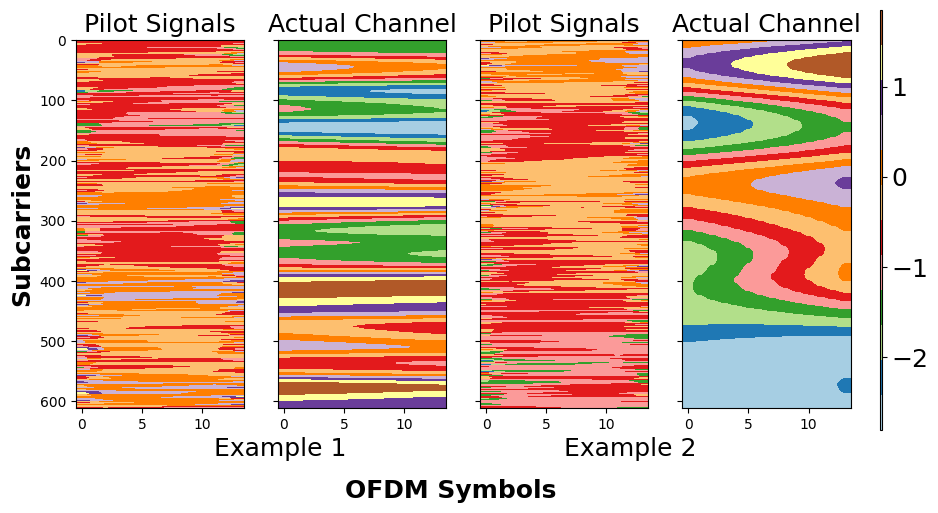

In [12]:
cmap_name = 'Paired'
font_size = 18

rand_idx = np.random.randint(0,valData.shape[0],2)

test_input1 = valData[rand_idx[0]:rand_idx[0]+1,:]
real_output1 = valLabels[rand_idx[0]:rand_idx[0]+1,:]

test_input2 = valData[rand_idx[1]:rand_idx[1]+1,:]
real_output2 = valLabels[rand_idx[1]:rand_idx[1]+1,:]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,6), sharey=True)

im1 = ax[0].imshow(test_input1.reshape(612,14), cmap=cmap_name)
ax[0].set_aspect(0.05)
ax[0].set_title('Pilot Signals',fontsize=font_size)

ax[1].imshow(real_output1.reshape(612,14), cmap=cmap_name)
ax[1].set_aspect(0.05)
ax[1].set_title('Actual Channel',fontsize=font_size)

im1 = ax[2].imshow(test_input2.reshape(612,14), cmap=cmap_name)
ax[2].set_aspect(0.05)
ax[2].set_title('Pilot Signals',fontsize=font_size)

ax[3].imshow(real_output2.reshape(612,14), cmap=cmap_name)
ax[3].set_aspect(0.05)
ax[3].set_title('Actual Channel',fontsize=font_size)

ax[0].set_ylabel('Subcarriers',fontsize=font_size, fontweight='bold')
fig.text(0.5,0.05, "OFDM Symbols", ha="center", va="center", fontsize=font_size, fontweight='bold')
fig.text(0.33,0.12, "Example 1", ha="center", va="center", fontsize=font_size, fontweight='normal')
fig.text(0.68,0.12, "Example 2", ha="center", va="center", fontsize=font_size, fontweight='normal')

cbar_ax = fig.add_axes([0.92, 0.152, 0.02, 0.7])
fig.colorbar(im1,cax=cbar_ax)
cbar_ax.set_aspect(50.5)
cbar_ax.tick_params(labelsize=font_size)

plt.show()

In [13]:
def get_model(mult_factor = 1.0, model_name=''):
    model = models.Sequential(name=model_name)
    # selu, softplus, selu
    model.add(layers.Conv2D(int(48*mult_factor), (9, 9), padding='same', activation='selu', input_shape=(612, 14, 1)))
    model.add(layers.Conv2D(int(16*mult_factor), (5, 5), padding='same', activation='softplus'))
    model.add(layers.Conv2D(1, (5, 5),  padding='same', activation='selu'))

    return model

In [14]:
model = get_model(1.0, model_name = 'FL-model')

es_teacher = EarlyStopping(monitor='val_loss',
                          patience=50,
                          verbose=1,
                          restore_best_weights=True,
                          mode='min')

model.compile(optimizer='adam',
                      loss='mse',
                      metrics=['mse'])
# Train and evaluate teacher on data.

hist_model = model.fit(trainData, trainLabels,
              epochs=10,
              verbose=0,batch_size=128,
              callbacks=[es_teacher,TqdmCallback(verbose=1, desc='DL training')],
              validation_data=(valData, valLabels))


2024-03-28 12:27:29.214760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 12:27:29.214969: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-28 12:27:29.215082: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-03-28 12:27:29.215177: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-03-28 12:27:29.215226: W tensorf

In [15]:
model.summary()

Model: "FL-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 612, 14, 48)       3936      
                                                                 
 conv2d_1 (Conv2D)           (None, 612, 14, 16)       19216     
                                                                 
 conv2d_2 (Conv2D)           (None, 612, 14, 1)        401       
                                                                 
Total params: 23,553
Trainable params: 23,553
Non-trainable params: 0
_________________________________________________________________


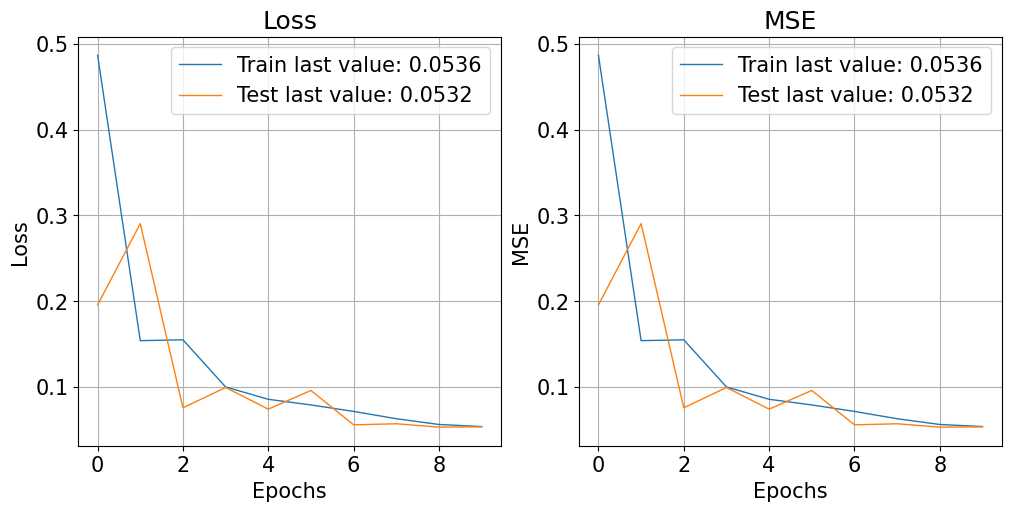

In [16]:

import matplotlib
matplotlib.rcParams.update({'font.size': 15})
plot_history(hist_model.history)
plt.savefig("undefended_training_history.pdf",bbox_inches='tight')
plt.show()


In [17]:
from Pyfhel import Pyfhel, PyPtxt, PyCtxt
import time

In [18]:
def gen_pk(s=128, alg_type='BFV'):
  HE = Pyfhel()

  HE.contextGen(p=65537, sec = s)
  HE.keyGen()
  #HE.relinKeyGen(60,4096)

  keys ={}
  keys['HE'] = HE
  keys['con'] = HE.to_bytes_context()
  keys['pk'] = HE.to_bytes_publicKey()

  return HE

In [19]:
def prep_df(num_of_clients,shuffle=True):
  trainData, trainLabels
  splitted_trainData = np.array_split(trainData,num_of_clients)
  splitted_trainLabels = np.array_split(trainLabels,num_of_clients)
  print (len(splitted_trainData))
  for i in range(len(splitted_trainData)):
    np.savez('client-' + str(i) + '.npz',
             trainData=splitted_trainData[i],
             trainLabels=splitted_trainLabels[i])

In [29]:
from Pyfhel import Pyfhel

# Assuming SECRET_LEVEL, LEVEL_N, and ALG_TYPE are defined as provided in your snippet
SECRET_LEVEL = 192
LEVEL_N = 2**13
ALG_TYPE = 'BFV'
HE = Pyfhel()

bfv_params = {
    "scheme": "BFV",  # can also be 'bfv'
    "n": 2**13,  # Polynomial modulus degree, the num. of slots per plaintext,
    #  of elements to be encoded in a single ciphertext in a
    #  2 by n/2 rectangular matrix (mind this shape for rotations!)
    #  Typ. 2^D for D in [10, 16]
    "t": 65537,  # Plaintext modulus. Encrypted operations happen modulo t
    #  Must be prime such that t-1 be divisible by 2^N.
    "t_bits": 20,  # Number of bits in t. Used to generate a suitable value
    #  for t. Overrides t if specified.
    "sec": 128,  # Security parameter. The equivalent length of AES key in bits.
    #  Sets the ciphertext modulus q, can be one of {128, 192, 256}
    #  More means more security but also slower computation.
}
HE.contextGen(**bfv_params)
# Example of context generation with p=65537 (a common plaintext modulus) and m=2048 (polynomial modulus degree).
# Adjust these parameters as needed for your use case.
# HE.contextGen(p=65537, m=LEVEL_N)  # Use m for the polynomial modulus degree if needed
HE.keyGen()

keys = {}
keys['HE'] = HE
keys['con'] = HE.to_bytes_context()
public_key_file = "temp_public_key.pem"
secret_key_file = "temp_secret_key.pem"

# Save keys to files
HE.savepublicKey(public_key_file)
HE.savesecretKey(secret_key_file)

HE.loadPublicKey("public_key.pem")
HE.loadSecretKey("secret_key.pem")


AttributeError: 'Pyfhel.Pyfhel.Pyfhel' object has no attribute 'savepublicKey'

In [23]:
SECRET_LEVEL = 192
LEVEL_N = 1024
ALG_TYPE = 'BFV'
HE=gen_pk(s=SECRET_LEVEL, alg_type=ALG_TYPE)
keys ={}
keys['HE'] = HE
keys['con'] = HE.to_bytes_context()
keys['pk'] = HE.to_bytes_publicKey()
keys['sk'] = HE.to_bytes_secretKey()

TypeError: contextGen() takes at least 2 positional arguments (0 given)

In [22]:
SECRET_LEVEL = 128
LEVEL_N =  2**13
ALG_TYPE = 'BFV'
HE=gen_pk(s=SECRET_LEVEL, alg_type=ALG_TYPE)
bfv_params = {
    "scheme": "BFV",  # can also be 'bfv'
    "n": 2**13,  # Polynomial modulus degree, the num. of slots per plaintext,
    #  of elements to be encoded in a single ciphertext in a
    #  2 by n/2 rectangular matrix (mind this shape for rotations!)
    #  Typ. 2^D for D in [10, 16]
    "t": 65537,  # Plaintext modulus. Encrypted operations happen modulo t
    #  Must be prime such that t-1 be divisible by 2^N.
    "t_bits": 20,  # Number of bits in t. Used to generate a suitable value
    #  for t. Overrides t if specified.
    "sec": 128,  # Security parameter. The equivalent length of AES key in bits.
    #  Sets the ciphertext modulus q, can be one of {128, 192, 256}
    #  More means more security but also slower computation.
}
HE.contextGen(**bfv_params)
keys ={}
keys['HE'] = HE
keys['con'] = HE.to_bytes_context()
keys['pk'] = HE.to_bytes_publicKey()
keys['sk'] = HE.to_bytes_secretKey()

TypeError: contextGen() takes at least 2 positional arguments (0 given)

In [ ]:
HE = Pyfhel()  # Creating empty Pyfhel object
bfv_params = {
    "scheme": "BFV",  # can also be 'bfv'
    "n": 2**13,  # Polynomial modulus degree, the num. of slots per plaintext,
    #  of elements to be encoded in a single ciphertext in a
    #  2 by n/2 rectangular matrix (mind this shape for rotations!)
    #  Typ. 2^D for D in [10, 16]
    "t": 65537,  # Plaintext modulus. Encrypted operations happen modulo t
    #  Must be prime such that t-1 be divisible by 2^N.
    "t_bits": 20,  # Number of bits in t. Used to generate a suitable value
    #  for t. Overrides t if specified.
    "sec": 128,  # Security parameter. The equivalent length of AES key in bits.
    #  Sets the ciphertext modulus q, can be one of {128, 192, 256}
    #  More means more security but also slower computation.
}
HE.contextGen(**bfv_params)  # Generate context for bfv scheme
HE.keyGen()  # Key Generation: generates a pair of public/secret keys
HE.rotateKeyGen()  # Rotate key generation --> Allows rotation/shifting
HE.relinKeyGen()  # Relinearization key generation

print("\n1. Pyfhel FHE context generation")
print(f"\t{HE}")